# Instacart Market Basket Analysys
Si no tenemos los paquetes instalados, los instalamos 

In [1]:
list_of_packages = c("tidyr", "arules", "knitr", "arulesViz", "here", "tidyverse", "ggplot2", "ggthemes", "repr", "methods")
new_packages = list_of_packages[!(list_of_packages %in% installed.packages()[,"Package"])]
if(length(new_packages)) install.packages(new_packages)


Importamos los paquetes instalados


In [2]:
suppressWarnings(suppressMessages(easypackages::libraries(list_of_packages)))

Cargamos los archivos de trabajo

In [3]:
path =  here::here("datos", "instacart-market-basket-analysis")

name_orders = "orders.csv"
name_dep = "departments.csv"

name_op_train = "order_products__train.csv"
name_products = "products.csv"
name_sample = "sample_submission.csv"

b_orders = read.csv(file = file.path(path, name_orders),
                  sep = ",")
b_dep = read.csv(file = file.path(path, name_dep),
                  sep = ",")
b_op_train = read.csv(file = file.path(path, name_op_train),
                  sep = ",")
b_products = read.csv(file = file.path(path, name_products),
                  sep = ",")
b_sample = read.csv(file = file.path(path, name_sample),
                  sep = ",")


Asignamos los archivos a los df

In [4]:
df_orders = b_orders
df_dep = b_orders
df_op_train = b_op_train
df_products =  b_products
df_sample =  b_sample


Los archivos llamados df_op son los que tienen la información de las ordenes de compra con los productos comprados, teniendo una fila por producto vendido. Analizamos la estructura:

In [5]:
print('/n df_op_train')
print(str(df_op_train))
print('/n')
print(summary(df_op_train))

[1] "/n df_op_train"
'data.frame':	1384617 obs. of  4 variables:
 $ order_id         : int  1 1 1 1 1 1 1 1 36 36 ...
 $ product_id       : int  49302 11109 10246 49683 43633 13176 47209 22035 39612 19660 ...
 $ add_to_cart_order: int  1 2 3 4 5 6 7 8 1 2 ...
 $ reordered        : int  1 1 0 0 1 0 0 1 0 1 ...
NULL
[1] "/n"
    order_id         product_id    add_to_cart_order   reordered     
 Min.   :      1   Min.   :    1   Min.   : 1.000    Min.   :0.0000  
 1st Qu.: 843370   1st Qu.:13380   1st Qu.: 3.000    1st Qu.:0.0000  
 Median :1701880   Median :25298   Median : 7.000    Median :1.0000  
 Mean   :1706298   Mean   :25556   Mean   : 8.758    Mean   :0.5986  
 3rd Qu.:2568023   3rd Qu.:37940   3rd Qu.:12.000    3rd Qu.:1.0000  
 Max.   :3421070   Max.   :49688   Max.   :80.000    Max.   :1.0000  


In [6]:
head(df_op_train)

order_id,product_id,add_to_cart_order,reordered
1,49302,1,1
1,11109,2,1
1,10246,3,0
1,49683,4,0
1,43633,5,1
1,13176,6,0


In [7]:
nrow(df_op_train)

[1] 1384617

In [8]:
head(df_products,1)


product_id,product_name,aisle_id,department_id
1,Chocolate Sandwich Cookies,61,19


Para tener mayor interpretación de las reglas, en vez del product_id utilizaremos la descripción.

In [9]:
df_op_train = merge(df_op_train, df_products, by = "product_id", all.x = T, all.y = F) 

Analizamos ahora la cantidad de pedidos, y la cantidad de elementos por pedido

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

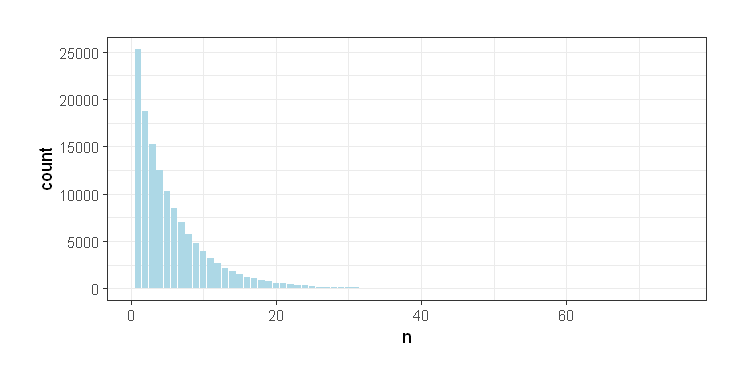

In [10]:
options(repr.plot.width=6.2, repr.plot.height=3.2)
options(dplyr.summarise.inform = FALSE)

p = df_op_train %>% 
    group_by(order_id) %>% 
    summarise(n = last(add_to_cart_order)) %>% 
    ggplot(aes(x = n)) +
    geom_histogram(stat = 'count', 
                   fill = 'lightblue',
                   ) +
                    theme_bw() +
                    theme(plot.margin = margin(.8,.8,.8,.8, "cm")) 

suppressMessages(p)

Seleccionaremos ahora las ordenes que tengan los 100 productos mas vendidos

In [11]:
top_100 = df_op_train %>% 
         group_by(product_id) %>% 
         summarise(n = n()) %>% 
         top_n(100, wt = n) 


top_100 = top_100[order(-top_100$n),]
df_op_train_filtered = df_op_train %>% 
                         filter(product_id %in% top_100$product_id)
print(paste0('Eliminamos ', as.character(nrow(df_op_train)-nrow(df_op_train_filtered)), ' filas y nos quedamos con ', as.character(nrow(df_op_train_filtered) )) )

[1] "Eliminamos 1069039 filas y nos quedamos con 315578"


Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

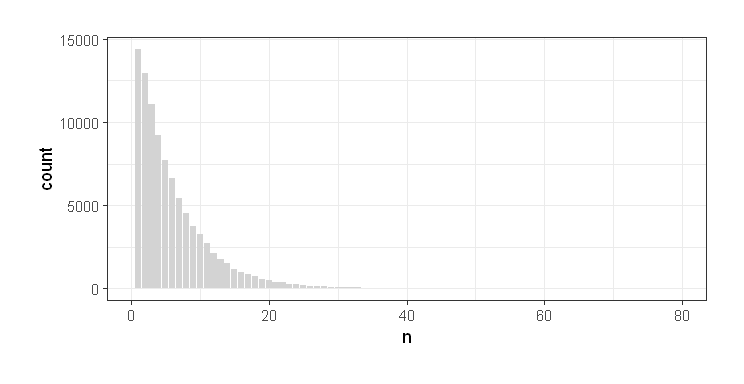

In [12]:
options(repr.plot.width=6.2, repr.plot.height=3.2)
options(dplyr.summarise.inform = FALSE)

p1 = df_op_train_filtered %>% 
    group_by(order_id) %>% 
    summarise(n = last(add_to_cart_order)) %>% 
    ggplot(aes(x = n)) +
    geom_histogram(stat = 'count', 
                   fill = 'lightgrey',
                   ) +
                    theme_bw() +
                    theme(plot.margin = margin(.8,.8,.8,.8, "cm")) 

suppressMessages(p1)

In [13]:
median(df_op_train_filtered$add_to_cart_order)

[1] 6

In [14]:
summary(df_op_train_filtered$add_to_cart_order)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   6.000   7.812  11.000  79.000 

Filtramos el DF en con el 75% de las observaciones y nos quedamos con todas las ordenes que tengan 11 productos o menos.

In [15]:
nrow(df_op_train_filtered)

[1] 315578

In [16]:
id_orders = df_op_train_filtered %>% 
            group_by(order_id) %>% 
            summarise(n = last(add_to_cart_order)) %>% 
            filter(n <= 11) %>% 
            select(-n)

df_op_train_filtered = merge(df_op_train_filtered, id_orders, by = "order_id", all.x = F, all.y = F) %>% 
                      select(-reordered)

In [17]:
print(nrow(df_op_train_filtered))
print(summary(df_op_train_filtered$add_to_cart_order))

[1] 247674
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   5.000   6.494   9.000  77.000 


Vamos a trasponer el df para que nos queden columnas categoricas por orden donde diga si o no contiene a ese producto.

In [18]:
productos = data.frame(unique(df_op_train_filtered$product_id)) %>% 
            rename('product_id' = unique.df_op_train_filtered.product_id.)
nrow(productos)

[1] 101

Nos quedaran 101 columnas de productos

In [21]:

q_productos = df_op_train_filtered %>% 
            group_by(order_id) %>% 
            summarise(cantidad_productos = last(add_to_cart_order))


In [22]:
df_op = df_op_train_filtered %>% 
        mutate(bandera = 1) %>%
        select(-add_to_cart_order) %>% 
        pivot_wider(names_from = product_name, values_from = bandera)

In [23]:
df_op = merge(q_productos, df_op, by = "order_id", all.x = F, all.y = T)

df_op[is.na(df_op)] =  0

df_op = df_op %>% 
        mutate(cantidad_productos = as.factor(cantidad_productos))

df_op[sapply(df_op, is.numeric)] <- lapply(df_op[sapply(df_op, is.numeric)], 
                                       as.factor)

Tenemos entonces nuestro DF que nos permitira obtener las relgas de asociación


In [24]:
head(df_op)

order_id,cantidad_productos,product_id,aisle_id,department_id,Organic Whole String Cheese,Cucumber Kirby,Organic Hass Avocado,Bag of Organic Bananas,Asparagus,...,Orange Bell Pepper,Organic Large Extra Fancy Fuji Apple,Organic Navel Orange,Organic Blackberries,Yellow Onions,Green Onions,Organic Kiwi,Grated Parmesan,2% Reduced Fat Milk,Organic D'Anjou Pears
1,6,22035,21,16,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,49683,83,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,47209,24,4,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,13176,24,4,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
36,2,46979,83,4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
36,2,49235,53,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Convertimos nuestro df en una tabla del tipo "transactions". Luego, buscamos sólo las reglas con al menos 2 productos, un soporte mínimo del 10% y una confianza mínima del 80%.

In [25]:
trx = as(df_op[, -1], "transactions")
trx

transactions in sparse format with
 247674 transactions (rows) and
 381 items (columns)

In [26]:
reglas = apriori(data = trx, 
                 control = list(verbose = F),
                 parameter = list( minlen = 2, 
                                   supp   = 0.1, 
                                   conf   = 0.8, 
                                   maxlen = 20,
                                 target ="frequent itemset" )
                                  )

In [27]:
str(reglas)

Formal class 'itemsets' [package "arules"] with 4 slots
  ..@ items   :Formal class 'itemMatrix' [package "arules"] with 3 slots
  .. .. ..@ data       :Formal class 'ngCMatrix' [package "Matrix"] with 5 slots
  .. .. .. .. ..@ i       : int [1:21622703] 2 213 2 185 2 231 2 265 2 227 ...
  .. .. .. .. ..@ p       : int [1:5459088] 0 2 4 6 8 10 12 14 16 18 ...
  .. .. .. .. ..@ Dim     : int [1:2] 381 5459087
  .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. ..$ : NULL
  .. .. .. .. ..@ factors : list()
  .. .. ..@ itemInfo   :'data.frame':	381 obs. of  3 variables:
  .. .. .. ..$ labels   : chr [1:381] "cantidad_productos=1" "cantidad_productos=2" "cantidad_productos=3" "cantidad_productos=4" ...
  .. .. .. ..$ variables: Factor w/ 105 levels "100% Whole Wheat Bread",..: 12 12 12 12 12 12 12 12 12 12 ...
  .. .. .. ..$ levels   : Factor w/ 163 levels "0","1","10","10749",..: 2 30 71 102 134 143 147 149 158 3 ...
  .. .. ..@ itemsetInfo:'data.frame':	0 ob

In [28]:
summary(reglas)

set of 5459087 itemsets

most frequent items:
Feta Cheese Crumbles=0        Russet Potato=0      Unsalted Butter=0 
                202186                 202183                 202183 
           Red Onion=0  Organic Black Beans=0                (Other) 
                202180                 202180               20611791 

element (itemset/transaction) length distribution:sizes
      2       3       4 
   5759  202127 5251201 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   4.000   4.000   3.961   4.000   4.000 

summary of quality measures:
    support       transIdenticalToItemsets     count       
 Min.   :0.1000   Min.   :0                Min.   : 24768  
 1st Qu.:0.9172   1st Qu.:0                1st Qu.:227163  
 Median :0.9612   Median :0                Median :238076  
 Mean   :0.8079   Mean   :0                Mean   :200100  
 3rd Qu.:0.9707   3rd Qu.:0                3rd Qu.:240405  
 Max.   :0.9915   Max.   :0                Max.   :245579  

includes transact

In [ ]:
inspect(reglas)